In [1]:
import tensorflow as tf

from tensorflow import keras

In [2]:
print(tf.__version__, ' ', tf.keras.__version__)

2.3.0   2.4.0


----

# 5 Deep learning for computer vision

This topic introduces a new type of layer: the convolutional layer

Convnets - models with convolutional layers - are first-call choices for computer vision DL applications

We will learn 

- convnet assembly
- use with small training sets
- use of powerful pretrained convnets
- convnet visualisation 

----

## 5.100 Introduction to convnets

We begin with a simple convnet for the MNIST task

Six lines of code

Easily outperforms our previous dense-layer models

In [3]:
from tensorflow.keras import layers
from tensorflow.keras import models

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

A stack of '`Conv2D`' and '`MaxPooling2D`' layers - explanation to follow

A convnet accepts input tensors of shape (excluding the batch dimension)

`(image_height, image_width, 
 image_channels)` 

First layer: `input_shape=(28, 28, 1)` 

In [4]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 64)          36928     
Total params: 55,744
Trainable params: 55,744
Non-trainable params: 0
_________________________________________________________________


Output of every `Conv2D` and `MaxPooling2D` layer is a 3D tensor of shape `(height, width, channels)` 

Notice how the width and height dimensions 

shrink along the processing pipeline

Conv layer parameters:

`model.add(layers.Conv2D(64, (3, 3), activation='relu'))`

64 channels, a 3 x 3 patch (local receptive field), 

relu activation

The output tensor (of shape `(3, 3, 64)`) must be fed into a densely-connected classifier

`Dense` layer classifiers process 1D vectors - convnet output is a 3D tensor

We will have to flatten our 3D output to 1D, 

and then add a few `Dense` layers on top:

In [5]:
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

In [6]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten (Flatten)            (None, 576)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                3

The `(3, 3, 64)` convnet output is flattened into a `(3 * 3 * 64,)` vector (`576 = 3 * 3 * 64`) and then passed into two `Dense` layers

In [7]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

train_images = train_images.reshape((60000, 28, 28, 1))
train_images = train_images.astype('float32') / 255

test_images = test_images.reshape((10000, 28, 28, 1))
test_images = test_images.astype('float32') / 255

train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

In [8]:
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(train_images, train_labels, epochs=5, batch_size=64)

Epoch 1/5
938/938 [==============================] - 39s 42ms/step - loss: 0.1718 - accuracy: 0.9463
Epoch 2/5
938/938 [==============================] - 32s 34ms/step - loss: 0.0488 - accuracy: 0.9843
Epoch 3/5
938/938 [==============================] - 23s 24ms/step - loss: 0.0331 - accuracy: 0.9896
Epoch 4/5
938/938 [==============================] - 32s 34ms/step - loss: 0.0252 - accuracy: 0.9923
Epoch 5/5
938/938 [==============================] - 25s 27ms/step - loss: 0.0214 - accuracy: 0.9935


Evaluate on test data (not the approved DL workflow!):

In [9]:
test_loss, test_acc = model.evaluate(test_images, test_labels)

313/313 [==============================] - 1s 3ms/step - loss: 0.0287 - accuracy: 0.9906


In [10]:
test_acc

0.9905999898910522

The test accuracy over the earlier dense networks has been increased by at least one per cent - a significant improvement

----

## 5.110 The convolution operation

Previously, we built a fully-connected (dense layered) feedforward network 

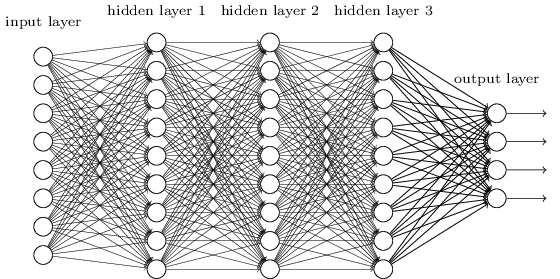

The architecture does not match the local structure of the images

Pixels that are far apart are treated the same way as pixels that are close

But images typically have local structure 

(edges, corners, shading etc)

And that local structures are repeated 

throughout the image 

Convolutional nets respect translational invariance of image detail

They are the natural choice for deep learning computer vision

They are smaller than dense layered models 

and faster to train 

 An MNIST sample is a 28 x 28 greyscale array

Let's imagine that each pixel is attached directly to an input unit (neuron):

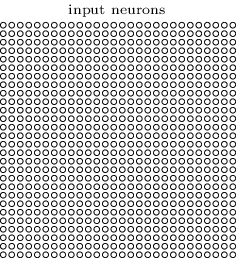

These input neurons are not usually coded in keras - 

just imagine a neutral layer of connections; 

neurons that pass any input without modification

A unit (neuron) in the first hidden layer - a convolutional layer - connected to 25 = 5 x 5 input pixel neurons

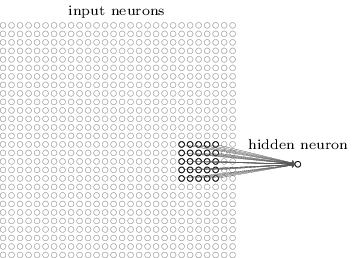

This 5 x 5 patch is also known as a local receptive field

Each connection is, as usual, weighted, and there is a single bias

That's 26 adjustable parameters

Each hidden neuron has its own receptive field

For example, here is a unit connected to the top left local receptive field:

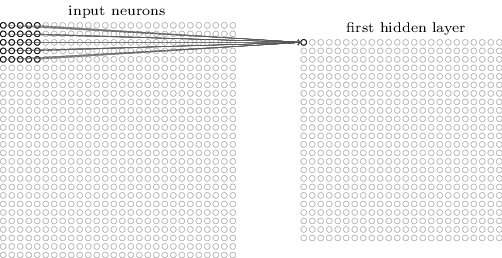

The local receptive field is moved across the image so that a single hidden convolutional unit connects to each field:

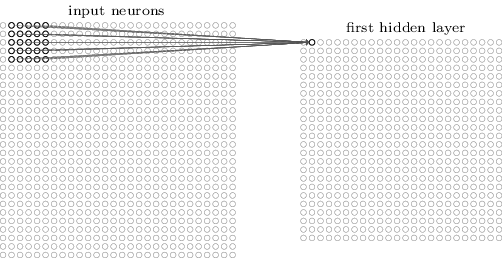

There are 24 x 24 neurons in the first hidden layer

The local receptive field is repeated by shifting one pixel at a time - a *stride* length of 1

Other stride lengths are possible, 

and other local receptive fields are possible too - 

DLWP sticks to 3 x 3 fields with a stride of 1

The weights and bias do not change even though the local receptive field is repeated across the image

There are precisely (5 x 5 + 1) parameters

The shared weights and bias are known as a *kernel* 

A single convolution acts as a *filter* 

A filter can detect a single feature

Perhaps it detects an edge

It can detect this edge at any location in the image - that's how the convolutional layer respects local image structure

The filter is a *feature map*, mapping the 

28 x 28 input image features to a smaller, 

24 x 24 dimensional 'image'.



But one filter can only detect one feature.

Use more filters for more features:

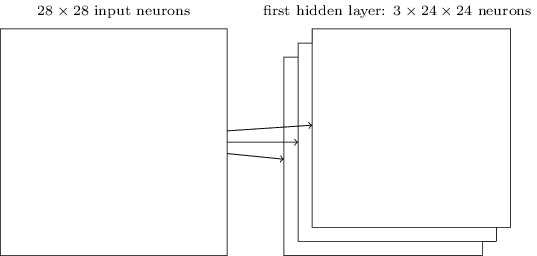

There are three features here - three channels

Let's calculate the number of parameters in the first layers of our convnet (ignoring the parameterless `max pooling` layer):

In [4]:
from tensorflow.keras import layers
from tensorflow.keras import models

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 64)        18496     
Total params: 18,816
Trainable params: 18,816
Non-trainable params: 0
_________________________________________________________________


`layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1))`

32 filters, each operating on a 3 x 3 local receptive field 

Hence there are 32 x (3 x 3 + 1) = 320 parameters

For comparison: the input layer of our earlier MNIST model

`layers.Dense(512, activation = 'relu', input_shape = (28 * 28,)`

has 512 * (28 * 28 + 1) = 401920 parameters

`model.add(layers.Conv2D(64, (3, 3), activation='relu'))` 

Each filter is connected, in 3 x 3 patches, to the 32 filters of the first conv layer

That's 9 x 32 weight paramaters plus a single bias - 

289 parameters

There are 64 second conv layer filters - 

289 x 64 = 18496 parameters 

----

## 5.120 Max pooling

Convnets also contain pooling layers

Pooling layers are usually used immediately after 

convolutional layers

Pooling layers simplify the information 

from the preceding convolutional layer

A pooling layer prepares a condensed feature map

For instance, each unit in the pooling layer may summarize a 2 x 2 patch in the previous layer

In *max-pooling*, a pooling unit simply outputs the maximum activation in the 2 × 2 input region:

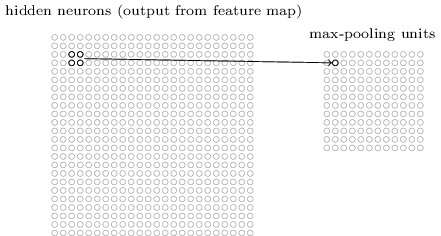

There are 24 × 24 neurons in the depicted convolutional layer

and 12 × 12 neurons in the pooling layer (2 x 2 pooling patch)

The feature map has been halved in size

Max-pooling is applied to each feature map separately 

So if there were three feature maps, the combined convolutional and max-pooling layers would look like:

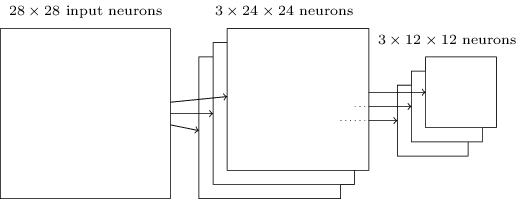

(Each feature map has a 5 x 5 local receptive field

hence there are 24 x 24 neurons in the filter)

 

Usually: 

- 3 x 3, stride 1, filter patches
- 2 x 2, stride 2, pooling patches 



L2 pooling: take the square root of the sum of the squares of the patch activations

Average pooling: average rather than max

Max-pooling is arguably preferential - it is more informative to look at the maximal presence of a feature rather than risk 

diluting the presence by taking an average 

The intuition behind any type of pooling 

is similar - pooling is a way of condensing information

Pooling not only downsamples (and therefore reduces parameter count) but it also widens the effective receptive field seen by the next layer

For example, in 2 x 2, stride 2 pooling, 

a 6 x 6 patch in conv layer 1 is reduced to a 3 x 3 patch in the pooling layer

This 3 x 3 patch is seen by a single neuron 

in conv layer 2

the neuron's field of vision has increased 

from 3 x 3 to 6 x 6

----

MIT Licence
 
Copyright (c) 2017-present François Chollet
 
Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:
 
The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.
 
THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.

Creative Commons LIcence

Copyright (c) 2015-present Michael A. Nielsen 

Creative Commons Attribution-NonCommercial 3.0 Unported License
https://creativecommons.org/licenses/by-nc/3.0/deed.en_GB